# **LAB 2 - PART 2 SVR**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR


import yfinance as yf


/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [ ]:
from sklearn.metrics import mean_squared_error

### **Retrieve the Financial Data**
Historical stock prices for a set of stocks, foreign exchange rates, and key market indices.

Ticker:
- stock tickers : `stk_tickers = ['MSFT', 'IBM', 'GOOGL']`
- foreign exchange tickers : `ccy_tickers = ['DEXJPUS', 'DEXUSUK']`
- market index tickers : `idx_tickers = ['SP500', 'DJIA', 'VIXCLS']`

<details>

<summary>
<font size="3" color="green">
<b>Hints</b>
</font>
</summary>

- `yf.download()`
- `web.DataReader()`
</details>

In [ ]:
!pip install --upgrade pandas-datareader
import pandas_datareader.data as web

In [ ]:
### START CODE HERE ###
stk_tickers = ["MSFT","IBM","GOOGL"]
ccy_tickers = ['DEXJPUS', 'DEXUSUK']
idx_tickers = ['SP500', 'DJIA', 'VIXCLS']
stk_data = yf.download(stk_tickers,start='2018-12-31', end='2023-12-31')
#stk_data = yf.download(stk_tickers,start='2018-12-31', end='2023-12-31')['Adj Close']
ccy_data = web.DataReader(ccy_tickers, 'fred',start='2018-12-31', end='2023-12-31')
idx_data = web.DataReader(idx_tickers, 'fred',start='2018-12-31', end='2023-12-31')
### END CODE HERE ###

# ดึงข้อมูลหุ้นที่ต้องการ โดยใช้ web.DataReader โดยกำหนดช่วงข้อมูลตั้งแต่ 2018-12-31 - 2023-12-31

[*********************100%%**********************]  3 of 3 completed


### **Exploring the Data**

In [ ]:
# stk_data.reset_index(drop=True, inplace=True)
stk_data
cls_msft = pd.DataFrame(stk_data['Adj Close','MSFT'])

In [ ]:

#ccy_data.dropna(inplace=True)
#ccy_data.reset_index(drop=True, inplace=True)
ccy_data

In [ ]:
#idx_data.dropna(inplace=True)
#idx_data.reset_index(drop=True, inplace=True)
idx_data

Let's
- `base` be stk_data's `'Adj Close'` and `'MSFT'`<br>
- `X1` be `stk_data`'s `'Adj Close'` and `('GOOGL','IBM')`<br>
- `X2` be `ccy_data`<br>
- `X3` be `idx_data`


In [ ]:
### START CODE HERE ###
base = np.log(stk_data.loc[:, ('Adj Close', 'MSFT')])
X1 = np.log(stk_data.loc[:, ('Adj Close', ('GOOGL', 'IBM'))])

X2 = np.log(ccy_data)
X3 = np.log(idx_data)

### END CODE HERE ###
# นำข้อมูลจาก stl_data มาแบ่งส่วนที่เป็น Adj Close' and 'MSFT' ออกมาเก็บใน base และ 'Adj Close' and ('GOOGL','IBM') เก็บไว้ใน X1

Create lagged and differenced features for time series analysis<br>
- `Y` : difference price of `'Adj Close', 'MSFT'` for past `n` days.
- `X4_[k]DT` : difference price of `'Adj Close', 'MSFT'` for past or next `[k]*n` days. Please select 3 values for `k`.
Concatenate the resulting features `X4_[k[0]]DT`, `X4_[k[1]]DT`, `X4_[k[2]]DT` into a single feature set `X4`. Finally, standardize the values in `X4`.<br>
(See detail explanation in lab direction)


<details>

<summary>
<font size="3" color="green">
<b>Hints</b>
</font>
</summary>

- `.diff()`
- `.shift()`
</details>

In [ ]:
### START CODE HERE ###
return_period = 3
k = [3, 6, 12]

Y = base.shift(-return_period)
print(base)
print(Y)
### Choose calculation of difference price either past (Guide#1) or next (Guide#2)

### Guide#1 for using price of past [k]*n days
X4_3DT = pd.DataFrame({'MSFT_3DT':base.diff(k[0]*return_period)})
X4_6DT = pd.DataFrame({'MSFT_6DT':base.diff(k[1]*return_period)})
X4_12DT = pd.DataFrame({'MSFT_12DT':base.diff(k[2]*return_period)})

### Guide#2 for using price of next [k]*n days
# X4_3DT = pd.DataFrame({'MSFT_3DT':base.diff(k[0]*return_period).shift(-k[0]*return_period)})
# X4_6DT = pd.DataFrame({'MSFT_6DT':base.diff(k[1]*return_period).shift(-k[1]*return_period)})
# X4_12DT = pd.DataFrame({'MSFT_12DT':base.diff(k[2]*return_period).shift(-k[3]*return_period)})

# X4 = pd.concat([np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(i) for i in [return_period, return_period*3, return_period*6, return_period*12]], axis=1).dropna()


X4 = pd.concat([X4_3DT,X4_6DT,X4_12DT],axis=1)
X4
### END CODE HERE ##

# ตั้งค่า return_period = 3 เป็นช่วงเวลาย้อนหลังที่จะใช้ในการคํานวณ
# ตั้งค่า k = [3, 6, 12] เป็นช่วงเวลาย้อนหลังที่จะนํามาใช้คํานวณ difference ของราคา
# สร้าง feature โดยใช้ base.diff(k*return_period) เพื่อหาผลต่างของราคาย้อนหลัง
# นํา feature ทั้งหมดมารวมเข้าด้วยกันใน X4
# ดังนั้น X4 จะเป็น dataframe ที่มี feature เพื่อใช้ในการพยากรณ์ราคาหุ้นต่อไป

Date
2018-12-31    4.569031
2019-01-02    4.564591
2019-01-03    4.527109
2019-01-04    4.572569
2019-01-07    4.573843
                ...   
2023-12-22    5.925805
2023-12-26    5.926019
2023-12-27    5.924443
2023-12-28    5.927672
2023-12-29    5.929696
Name: (Adj Close, MSFT), Length: 1259, dtype: float64
Date
2018-12-31    4.572569
2019-01-02    4.573843
2019-01-03    4.581068
2019-01-04    4.595266
2019-01-07    4.588820
                ...   
2023-12-22    5.927672
2023-12-26    5.929696
2023-12-27         NaN
2023-12-28         NaN
2023-12-29         NaN
Name: (Adj Close, MSFT), Length: 1259, dtype: float64


,MSFT_3DT,MSFT_6DT,MSFT_12DT
Date,,,
2018-12-31,NaN,NaN,NaN
2019-01-02,NaN,NaN,NaN
2019-01-03,NaN,NaN,NaN
2019-01-04,NaN,NaN,NaN
2019-01-07,NaN,NaN,NaN
...,...,...,...
2023-12-22,0.008795,-0.021446,0.081192
2023-12-26,0.000748,-0.011121,0.074925
2023-12-27,-0.000802,-0.012856,0.060569


**Standardize `X1-4`**

***NOTE:*** Please ensure that each of ***X1-4's index columns*** is the ***date column***.

In [ ]:
### START CODE HERE ###
standard_scaler = preprocessing.StandardScaler()
X1_standardized = standard_scaler.fit_transform(X1)
X2_standardized = standard_scaler.fit_transform(X2)
X3_standardized = standard_scaler.fit_transform(X3)
X4_standardized = standard_scaler.fit_transform(X4)

print(X1)
print(X1_standardized)


X1 = pd.DataFrame(X1_standardized, index=X1.index, columns=X1.columns)
X2 = pd.DataFrame(X2_standardized, index=X2.index, columns=X2.columns)
X3 = pd.DataFrame(X3_standardized, index=X3.index, columns=X3.columns)
X4 = pd.DataFrame(X4_standardized, index=X4.index, columns=X4.columns)

print(X1)


### END CODE HERE ###
# ทำการ stadardized ข้อมูลทั้งหมดให้สามารถนำไปใช้งานได้

Price      Adj Close          
Ticker         GOOGL       IBM
Date                          
2018-12-31  3.956002  4.444399
2019-01-02  3.965260  4.457856
2019-01-03  3.937174  4.437691
2019-01-04  3.987195  4.476005
2019-01-07  3.985199  4.483055
...              ...       ...
2023-12-22  4.952229  5.088460
2023-12-26  4.952441  5.095038
2023-12-27  4.944282  5.096568
2023-12-28  4.943284  5.098341
2023-12-29  4.939426  5.097119

[1259 rows x 2 columns]
[[-1.8147994  -2.28341661]
 [-1.78589166 -2.18110935]
 [-1.87358282 -2.33441774]
 ...
 [ 1.27080081  2.67470136]
 [ 1.26768531  2.68817696]
 [ 1.25563926  2.67888593]]
Price      Adj Close          
Ticker         GOOGL       IBM
Date                          
2018-12-31 -1.814799 -2.283417
2019-01-02 -1.785892 -2.181109
2019-01-03 -1.873583 -2.334418
2019-01-04 -1.717406 -2.043133
2019-01-07 -1.723639 -1.989539
...              ...       ...
2023-12-22  1.295614  2.613059
2023-12-26  1.296276  2.663065
2023-12-27  1.270801  2.674701
2

Concatenate `X1-4` to `X` by index. Then concatenate `X` and `Y` to `dataset` by index.

***NOTE:*** Please ensure that each of ***X1-3's index columns*** is the ***date column***.

In [ ]:
### START CODE HERE ###



X = pd.concat([X1, X2, X3, X4], axis=1)

dataset = pd.concat([X, Y], axis=1)

X
### END CODE HERE ###

# concat ข้อมูลเข้าไปใน dataframe เดียวกัน

,"(Adj Close, GOOGL)","(Adj Close, IBM)",DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_3DT,MSFT_6DT,MSFT_12DT
2018-12-31,-1.814799,-2.283417,-0.649597,-0.080815,-2.198622,-2.064978,0.716321,NaN,NaN,NaN
2019-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-02,-1.785892,-2.181109,-0.686016,-0.331217,-2.191455,-2.058851,0.435116,NaN,NaN,NaN
2019-01-03,-1.873583,-2.334418,-0.773926,-0.277828,-2.333191,-2.277197,0.719985,NaN,NaN,NaN
2019-01-04,-1.717406,-2.043133,-0.757037,-0.115525,-2.142315,-2.030558,0.178652,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2023-12-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-26,1.296276,2.663065,1.521794,-0.162407,1.444351,1.558488,-1.369228,-0.192895,-0.473098,0.429990
2023-12-27,1.270801,2.674701,1.496692,-0.029619,1.452433,1.581002,-1.506121,-0.226169,-0.500084,0.259044
2023-12-28,1.267685,2.688177,1.439785,-0.110994,1.454525,1.591828,-1.496140,0.332920,-0.268100,0.172264


<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

| Date       | (Adj Close, GOOGL) | (Adj Close, IBM) | DEXJPUS   | DEXUSUK   | SP500    | DJIA     | VIXCLS   | MSFT_3DT | MSFT_6DT | MSFT_12DT | (Adj Close, MSFT) |
|------------|--------------------|-------------------|-----------|-----------|----------|----------|----------|----------|----------|-----------|-------------------|
| 2018-12-31 | -1.545378          | -1.993072         | -0.652377 | -0.107177 | -1.966763| -1.936393| 0.492393 | 0.455826 | 3.333092 | 9.376259  | 96.792442         |
| 2019-01-01 | NaN                | NaN               | NaN       | NaN       | NaN      | NaN      | NaN      | NaN      | NaN      | NaN       | NaN               |
| 2019-01-02 | -1.529007          | -1.918422         | -0.684528 | -0.3554   | -1.961748| -1.931557| 0.224562 | 3.693924 | 1.728264 | 10.394836 | 96.915886         |
| 2019-01-03 | -1.578206          | -2.029912         | -0.761557 | -0.302747 | -2.05974 | -2.10151 | 0.496045 | 7.577789 | 8.52739  | 14.661652 | 97.618576         |
| 2019-01-04 | -1.48961           | -1.816142         | -0.746821 | -0.141777 | -1.927197| -1.909175| 0.000558 | 3.978821 | 2.373985 | 10.178764 | 99.014511         |
| ...        | ...                | ...               | ...       | ...       | ...      | ...      | ...      | ...      | ...      | ...       | ...               |
| 2023-12-22 | 1.46086            | 2.989076          | 1.551328  | -0.171865 | 1.577892 | 1.683629 | -1.015981| NaN      | NaN      | NaN       | 375.279999        |
| 2023-12-25 | NaN                | NaN               | NaN       | NaN       | NaN      | NaN      | NaN      | NaN      | NaN      | NaN       | NaN               |
| 2023-12-26 | 1.46187            | 3.058317          | NaN       | NaN       | 1.60962  | 1.724664 | -1.020851| NaN      | NaN      | NaN       | NaN               |
| 2023-12-27 | 1.42313            | 3.074495          | NaN       | NaN       | 1.620391 | 1.753295 | -1.089026| NaN      | NaN      | NaN       | NaN               |
| 2023-12-28 | 1.418414           | 3.09326           | NaN       | NaN       | 1.623182 | 1.767092 | NaN      | NaN      | NaN      | NaN       | NaN               |

</details>

In [ ]:
# dataset = dataset.rename_axis('Date')
dataset

,"(Adj Close, GOOGL)","(Adj Close, IBM)",DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_3DT,MSFT_6DT,MSFT_12DT,"(Adj Close, MSFT)"
2018-12-31,-1.814799,-2.283417,-0.649597,-0.080815,-2.198622,-2.064978,0.716321,NaN,NaN,NaN,4.572569
2019-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-02,-1.785892,-2.181109,-0.686016,-0.331217,-2.191455,-2.058851,0.435116,NaN,NaN,NaN,4.573843
2019-01-03,-1.873583,-2.334418,-0.773926,-0.277828,-2.333191,-2.277197,0.719985,NaN,NaN,NaN,4.581068
2019-01-04,-1.717406,-2.043133,-0.757037,-0.115525,-2.142315,-2.030558,0.178652,NaN,NaN,NaN,4.595266
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-26,1.296276,2.663065,1.521794,-0.162407,1.444351,1.558488,-1.369228,-0.192895,-0.473098,0.429990,5.929696
2023-12-27,1.270801,2.674701,1.496692,-0.029619,1.452433,1.581002,-1.506121,-0.226169,-0.500084,0.259044,NaN
2023-12-28,1.267685,2.688177,1.439785,-0.110994,1.454525,1.591828,-1.496140,0.332920,-0.268100,0.172264,NaN


**Drop NA**

Drop NA from `dataset`.

<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

```
DatetimeIndex: 1207 entries, 2018-12-31 to 2023-11-06
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   (Adj Close, GOOGL)  1207 non-null   float64
 1   (Adj Close, IBM)    1207 non-null   float64
 2   DEXJPUS             1207 non-null   float64
 3   DEXUSUK             1207 non-null   float64
 4   SP500               1207 non-null   float64
 5   DJIA                1207 non-null   float64
 6   VIXCLS              1207 non-null   float64
 7   MSFT_3DT            1207 non-null   float64
 8   MSFT_6DT            1207 non-null   float64
 9   MSFT_12DT           1207 non-null   float64
 10  (Adj Close, MSFT)   1207 non-null   float64
dtypes: float64(11)
memory usage: 113.2 KB
```
<br>

| Statistic | (Adj Close, GOOGL) | (Adj Close, IBM) | DEXJPUS   | DEXUSUK   | SP500    | DJIA     | VIXCLS   | MSFT_3DT | MSFT_6DT | MSFT_12DT | (Adj Close, MSFT) |
|-----------|--------------------|-------------------|-----------|-----------|----------|----------|----------|----------|----------|-----------|-------------------|
| count     | 1207.000000        | 1207.000000       | 1207.000000 | 1207.000000 | 1207.000000 | 1207.000000 | 1207.000000 | 1207.000000 | 1207.000000 | 1207.000000 | 1207.000000 |
| mean      | -0.035934          | -0.076293         | -0.048627 | 0.010266  | -0.038274| -0.038135| 0.032071 | 2.003695 | 4.026331 | 8.035808  | 228.156289        |
| std       | 0.990693           | 0.898243          | 0.967200  | 1.011495 | 0.987860 | 0.988187 | 1.006162 | 11.217826 | 15.534667 | 20.737484 | 70.323041         |
| min       | -1.578206          | -2.638620         | -1.133307 | -3.206211 | -2.391674 | -3.155777 | -1.197376 | -33.900146 | -52.498260 | -60.695969 | 96.792442         |
| 25%       | -0.995937          | -0.771499         | -0.759213 | -0.719462 | -1.006790 | -0.968910 | -0.631888 | -3.104721 | -4.466766 | -1.814156 | 165.381950        |
| 50%       | 0.007967           | -0.093102         | -0.598791 | 0.029723  | 0.217450  | 0.238699  | -0.194228 | 2.514923 | 4.754410 | 9.164612  | 238.217758        |
| 75%       | 0.814595           | 0.512558          | 0.890217  | 0.725501  | 0.808928  | 0.821986  | 0.480219  | 8.710037 | 13.093704 | 20.562767 | 284.131805        |
| max       | 1.742090           | 2.083764          | 2.144788  | 2.036573  | 1.644014  | 1.532654  | 7.464517  | 35.238464 | 48.708038 | 72.977844 | 362.464325        |



</details>

In [ ]:
### START CODE HERE ###
dataset = dataset.dropna()
# dataset = dataset.drop_duplicates()
### END CODE HERE ###
dataset.info()
dataset.describe()

# นำข้อมูล dataset ที่ได้มา clean โดยการ dropna

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1206 entries, 2019-02-22 to 2023-12-26
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   (Adj Close, GOOGL)  1206 non-null   float64
 1   (Adj Close, IBM)    1206 non-null   float64
 2   DEXJPUS             1206 non-null   float64
 3   DEXUSUK             1206 non-null   float64
 4   SP500               1206 non-null   float64
 5   DJIA                1206 non-null   float64
 6   VIXCLS              1206 non-null   float64
 7   MSFT_3DT            1206 non-null   float64
 8   MSFT_6DT            1206 non-null   float64
 9   MSFT_12DT           1206 non-null   float64
 10  (Adj Close, MSFT)   1206 non-null   float64
dtypes: float64(11)
memory usage: 113.1 KB


,"(Adj Close, GOOGL)","(Adj Close, IBM)",DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_3DT,MSFT_6DT,MSFT_12DT,"(Adj Close, MSFT)"
count,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000
mean,0.044175,0.033166,0.015515,-0.004716,0.049586,0.043080,0.017010,-0.010387,-0.000655,0.001348,5.411741
std,0.972625,0.976966,1.007810,1.015454,0.961008,0.972928,1.011548,1.010338,1.010340,1.001670,0.330806
min,-1.833439,-3.230766,-1.211782,-3.468180,-2.841556,-3.792540,-1.736912,-4.388154,-5.344743,-3.303370,4.656564
25%,-0.831077,-0.706469,-0.770661,-0.724337,-0.827487,-0.822540,-0.725698,-0.523429,-0.602043,-0.563457,5.178488
50%,0.248655,0.067580,-0.546146,-0.039396,0.334817,0.399832,-0.081887,0.087135,0.098060,0.115384,5.488609
75%,0.910724,0.641437,1.029358,0.737224,0.874513,0.838082,0.697312,0.640539,0.656826,0.704481,5.668820
max,1.474606,2.732618,2.034884,1.956038,1.470118,1.561041,4.380597,2.997575,3.942040,3.093345,5.947251


Let's `Y` be `dataset`'s `Y` column and X be all `dataset`'s columns except `Y`.

In [ ]:
### START CODE HERE ###
Y = dataset[('Adj Close', 'MSFT')]

X = dataset.drop([('Adj Close', 'MSFT')],axis=1)

### END CODE HERE ###
# แบ่งข้อมูลใน ('Adj Close', 'MSFT') ออกมาจาก dataset แยกเป็น X Y เพื่อนำไปใช้ในการเทรน



```
# มีการจัดรูปแบบเป็นโค้ด
```

**Calculate the Correlation**

1. Drop columns that have correlation more than 0.9.
2. Show Dropped Columns

In [ ]:
### START CODE HERE ###
#X.corr()

correlation_matrix = X.corr()
print(correlation_matrix)
# Find columns with correlation greater than 0.9
highly_correlated_columns = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            colname = correlation_matrix.columns[i]
            highly_correlated_columns.add(colname)

# Show Dropped Columns
print("Dropped Columns:")
print(highly_correlated_columns)

# Drop highly correlated columns from the DataFrame
X_dropped = X.drop(columns=highly_correlated_columns)

# Display the modified DataFrame
# print("\nDataFrame after dropping highly correlated columns:")
# print(X_dropped)
### END CODE HERE ###

# ทำการเอา colomn ที่มี correlation มากกว่า 0.9 และน้อวยกว่า 1.0 ออก

                    (Adj Close, GOOGL)  (Adj Close, IBM)   DEXJPUS   DEXUSUK  \
(Adj Close, GOOGL)            1.000000          0.650779  0.507206  0.231181   
(Adj Close, IBM)              0.650779          1.000000  0.808098 -0.202032   
DEXJPUS                       0.507206          0.808098  1.000000 -0.599158   
DEXUSUK                       0.231181         -0.202032 -0.599158  1.000000   
SP500                         0.974310          0.709788  0.525579  0.230424   
DJIA                          0.920574          0.767023  0.522833  0.241354   
VIXCLS                       -0.063685         -0.401922 -0.115175 -0.230040   
MSFT_3DT                     -0.038911         -0.006112 -0.075458  0.112675   
MSFT_6DT                     -0.048379          0.003226 -0.106201  0.163779   
MSFT_12DT                    -0.091910         -0.035377 -0.176028  0.233399   

                       SP500      DJIA    VIXCLS  MSFT_3DT  MSFT_6DT  \
(Adj Close, GOOGL)  0.974310  0.920574 -0.06368

In [ ]:
X.columns

In [ ]:
X = X.drop(columns = [('Adj Close', 'GOOGL'),('Adj Close', 'IBM')])
# X = X.reset_index(drop=True)
# Y = Y.reset_index(drop=True)
X

,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_3DT,MSFT_6DT,MSFT_12DT
2019-02-22,-0.574232,0.372170,-1.588150,-1.229853,-1.247298,0.933631,0.614822,0.642527
2019-02-25,-0.546520,0.360385,-1.581190,-1.212284,-0.953520,1.138826,1.021649,0.761744
2019-02-26,-0.569732,0.642705,-1.585661,-1.222203,-0.887291,0.954443,0.617194,1.289959
2019-02-27,-0.557744,0.738307,-1.588738,-1.243509,-0.985058,0.934180,0.878720,0.728475
2019-02-28,-0.523372,0.674625,-1.604736,-1.263800,-0.985058,0.889261,1.107087,0.698423
...,...,...,...,...,...,...,...,...
2023-12-19,1.587980,-0.098916,1.436791,1.561041,-1.481229,0.049218,-0.490224,1.035639
2023-12-20,1.596649,-0.236744,1.353150,1.463947,-1.210724,-0.228067,-0.583358,0.683360
2023-12-21,1.503120,-0.224588,1.411097,1.529846,-1.215273,-0.248588,-0.509820,0.748604
2023-12-22,1.528786,-0.145758,1.420475,1.526103,-1.359677,-0.020061,-0.633743,0.504616


### **Train/Test Model**

**Train/Test Split**

Split the dataset into training and testing sets. Reserve frist 70% of data for training and last 30% for testing.


In [ ]:
### START CODE HERE ###
test_size = 0.3
train_size = 0.7
X_train, X_test = train_test_split(X,test_size=test_size)
Y_train, Y_test = train_test_split(Y,test_size=test_size)
### START CODE HERE ###
X_train.columns = ['Adj Close, IBM',	'DEXJPUS'	,'DEXUSUK'	,'DJIA',	'VIXCLS','MSFT_3DT',	'MSFT_6DT'	,'MSFT_12DT']
X_test.columns = ['Adj Close, IBM',	'DEXJPUS'	,'DEXUSUK'	,'DJIA',	'VIXCLS','MSFT_3DT',	'MSFT_6DT'	,'MSFT_12DT']
X_train.index = pd.to_datetime(X_train.index)
X_train = X_train.sort_index()

X_test.index = pd.to_datetime(X_test.index)
X_test = X_test.sort_index()

Y_train.index = pd.to_datetime(Y_train.index)
Y_train = Y_train.sort_index()

Y_test.index = pd.to_datetime(Y_test.index)
Y_test = Y_test.sort_index()



scaler = preprocessing.StandardScaler()
scaler.fit(cls_msft)

Y_test_df = pd.DataFrame(Y_test.array,columns=['Adj Close,MSFT'],index=Y_test.index)
Y_test_df = pd.DataFrame(scaler.inverse_transform(Y_test_df),columns=Y_test_df.columns,index=Y_test_df.index)
Y_test_df.index = pd.to_datetime(Y_test_df.index)
Y_test_df = Y_test_df.sort_index()

Y_test_df

# แบ่งข้อมูลที่ใช้ train:test ออกเป็น 7:3 แล้ว sort ข้อมูลด้วย date time

,"Adj Close,MSFT"
2019-02-22,575.090565
2019-03-05,573.994724
2019-03-12,577.501192
2019-03-13,578.546336
2019-03-26,578.777278
...,...
2023-11-28,667.188602
2023-11-29,666.127098
2023-12-04,666.486602
2023-12-12,666.442998


**Initialize models**
- `Linear Regression`
- `Support Vector Regression` which `kernels` are `['linear','rbf','poly']` and `C` value are `[0.1, 1, 10, 100]`
- `Linear Regression` with `Gradient Descent` from `Lab2-2`


<details>

<summary>
<font size="3" color="green">
<b>Hints</b>
</font>
</summary>

- `LinearRegression()`
- `SVR()`
</details>

In [ ]:
kernels = ['linear','rbf','poly']
c_value = [0.1, 1, 10, 100]
gamma = 0.01
degree = 2

svr_prediction_df = pd.DataFrame(Y_test_df,columns=['Y_test'])
mse_kernels = []


for k in kernels :
  for c in c_value:
    svr_model = SVR(kernel=k,C=c,gamma=gamma,degree=degree)
    svr_model.fit(X_train, Y_train)

    y_pred = svr_model.predict(X_test)
    y_pred_df = pd.DataFrame(y_pred,columns=[f'SVR {k} C= {c}'])

    mse = mean_squared_error(Y_test, y_pred)
    mse_kernels.append(mse)

    y_pred_df = pd.DataFrame(scaler.inverse_transform(y_pred_df),columns=y_pred_df.columns,index=Y_test_df.index)
    svr_prediction_df = pd.concat([svr_prediction_df,y_pred_df],axis=1)


svr_prediction_df.drop(columns=['Y_test'],inplace=True)
print(mse_kernels)
svr_prediction_df

# กําหนด parameter ต่างๆของโมเดล SVR ได้แก่ kernels, c_value, gamma, degree
# วนลูปทดสอบโมเดลกับทุกๆ combination ของ parameters
# Train โมเดล SVR แล้วทํานายค่า Y ของ testing set (y_pred)
# คํานวณค่า MSE ของแต่ละโมเดลเพื่อ evaluate performance
# เก็บค่าทํานาย y_pred และ mse ของแต่ละโมเดลไว้ใน dataframe
# สุดท้ายจะได้ dataframe ที่มีค่าทํานายจากโมเดล SVR หลายๆ โมเดลพร้อมกับ mse ของแต่ละโมเดล

[0.006950060121602018, 0.006861664798286648, 0.006922720565887417, 0.006871344011164465, 0.008818083838997392, 0.0074389370247449575, 0.006342115302690952, 0.006917745928484672, 0.09986546935552322, 0.06888447443806585, 0.04284789095435982, 0.0357455108780495]


,SVR linear C= 0.1,SVR linear C= 1,SVR linear C= 10,SVR linear C= 100,SVR rbf C= 0.1,SVR rbf C= 1,SVR rbf C= 10,SVR rbf C= 100,SVR poly C= 0.1,SVR poly C= 1,SVR poly C= 10,SVR poly C= 100
2019-02-22,586.199155,585.261218,585.162534,585.180283,593.501044,586.433103,582.041403,578.967872,632.604968,618.144976,591.181033,587.649042
2019-03-05,584.930019,584.199401,584.075765,584.114959,592.044845,584.579810,580.662287,578.709712,632.587878,617.232283,588.253540,586.399114
2019-03-12,584.802023,584.126637,583.994898,584.037824,591.741105,585.050557,582.196278,580.469440,632.904763,619.117730,593.536305,593.473817
2019-03-13,583.407469,583.043384,582.908522,582.947268,589.813961,582.827412,580.273767,578.439783,632.779909,617.256678,586.063999,586.612295
2019-03-26,584.605629,584.582175,584.456794,584.495951,589.557398,582.369525,580.163108,579.238782,632.563296,615.449302,581.012230,582.275173
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-28,658.576638,659.270669,659.267173,659.237883,658.464128,662.094388,664.381192,665.083657,634.272944,640.060649,656.464898,661.201794
2023-11-29,655.987161,656.466394,656.450984,656.420003,657.507676,660.256156,661.597864,661.110903,634.177654,636.662134,650.448866,654.532850
2023-12-04,656.927026,657.486431,657.500178,657.448590,657.465376,660.417355,660.967982,660.795411,634.067333,635.536023,647.234180,650.086171
2023-12-12,656.982180,657.632736,657.643796,657.592165,657.601802,660.851610,661.573639,661.812334,634.083578,637.056121,650.977821,653.756916


**Train models**

Train all models with at least two X's columns.

<span style='color: orange;'>**BONUS POINTS**</span> for those who train with more than two or all X's columns.

<details>

<summary>
<font size="3" color="green">
<b>Hints</b>
</font>
</summary>

- `.fit()`
- For the gradient descent, you'll need to perform multivariate gradient descent by yourself. Vectorizing or using matrices might make things easier.
</details>

In [ ]:
linear_regression_model = LinearRegression()
linear_regression_model.fit(X_train,Y_train)
y_linear_regression_predict = linear_regression_model.predict(X_test)
mse_linear_regression = mean_squared_error(Y_test, y_linear_regression_predict)
y_linear_regression_predict_df = pd.DataFrame(y_linear_regression_predict,columns=['Linear Regression Predictions'])
y_linear_regression_predict_df =  pd.DataFrame(scaler.inverse_transform(y_linear_regression_predict_df),columns=y_linear_regression_predict_df.columns,index=Y_test_df.index)
print(mse_linear_regression)

#
# สร้างออบเจ็กต์ linear_regression_model โดยใช้ class LinearRegression
# ฝึกสอน (Train) โมเดลด้วยข้อมูล training set (X_train, Y_train)
# ใช้โมเดลที่ฝึกสอนแล้วเพื่อทํานายค่า Y ของ testing set (X_test) โดยเก็บไว้ใน y_linear_regression_predict
# คํานวณ Mean Squared Error (MSE) ระหว่างค่าจริง (Y_test) กับค่าทํานาย เพื่อประเมินประสิทธิภาพโมเดล
# แปลงข้อมูลทํานายกลับไปอยู่ใน scale เดิมด้วย scaler.inverse_transform
# แสดงผลลัพธ์ค่า MSE ของโมเดล

0.006577061040697177


**Evaluate models**

Evaluate models with test set


<details>

<summary>
<font size="3" color="green">
<b>Hints</b>
</font>
</summary>

- `.predict()`
</details>

In [ ]:
def LinearGradientDescent(X, y, learning_rate, num_iterations):
    if isinstance(X, pd.DataFrame):
        X = X.values
    if isinstance(y, pd.Series):
        y = y.values.reshape(-1, 1)

    m, n = X.shape
    theta = np.zeros((n, 1))
    y_intercept = 0

    theta_history = []
    theta0_history = []
    loss_history = []

    for _ in range(num_iterations):
        # Hypothesis function
        h = np.dot(X, theta) + y_intercept

        # Compute the gradient for weights
        grad_J_theta = np.dot(X.T, (h - y)) / m

        # Update weights
        theta = theta - learning_rate * grad_J_theta

        # Compute the gradient for the y-intercept
        grad_J_intercept = np.sum(h - y) / m

        # Update y-intercept correctly using the gradient
        y_intercept = y_intercept - learning_rate * grad_J_intercept

        mse = np.sum((h - y)**2) / m
        # Save history for visualization or analysis
        theta_history.append(theta.copy())
        theta0_history.append(y_intercept)
        loss_history.append(mse)

    return theta, y_intercept, theta_history, theta0_history, loss_history

learning_rate = 0.01
num_iterations = 10000

best_theta, best_y_intercept, weight_history, y_intercept_history, loss_history = LinearGradientDescent(X=X_train, y=Y_train, learning_rate=learning_rate,num_iterations=num_iterations)

y_gradient_descent_predict = np.dot(X_test, best_theta) + best_y_intercept
mse_linear_gradient_descent = mean_squared_error(Y_test, y_gradient_descent_predict)
mse_linear_gradient_descent

#
# กําหนดค่า Hyperparameter ได้แก่ learning rate และจํานวนรอบของ Gradient Descent (num_iterations)
# วนลูป Gradient Descent เพื่ออัพเดตค่า weight (theta) และ y-intercept ตามสมการที่กําหนด
# ในแต่ละรอบจะคํานวณ Loss (Mean squared error) เพื่อ evaluate
# เก็บประวัติของค่า theta, y_intercept และ loss ไว้ด้วย
# ใช้ theta และ y_intercept ที่ได้ ไปทํานายค่า Y ของ Testing Set แล้ววัดประสิทธิภาพด้วย MSE

0.006958412689519469

**Compare MSE from all models**

In [ ]:
### START CODE HERE ###
print("--------MSE--------")
print("Linear Regression:",mse_linear_regression)
print("SVR (kernel:linear):",mse_kernels[0:4])
print("SVR (kernel:rbf):",mse_kernels[4:8])
print("SVR (kernel:poly):",mse_kernels[8:12])
print("Linear with Gradient Descent:",mse_linear_gradient_descent)
### END CODE HERE ###

แสดงผลลัพธ์ Mean Squared Error (MSE) ของโมเดลต่างๆ เพื่อนํามาเปรียบเทียบประสิทธิภาพกัน

มีขั้นตอนดังนี้

แสดงค่า MSE ของ Linear Regression
แสดงค่า MSE ของ SVR ในแต่ละ kernel (linear, rbf, poly)
แสดงค่า MSE ของ Linear Regression ที่ใช้ Gradient Descent
ดังนั้นจากผลลัพธ์ที่แสดง ก็จะสามารถดูได้ว่า โมเดลไหนมีประสิทธิภาพดีที่สุด (MSE ต่ําที่สุด) เพื่อนําไปใช้ต่อไปได้

--------MSE--------
Linear Regression: 0.006577061040697177
SVR (kernel:linear): [0.006950060121602018, 0.006861664798286648, 0.006922720565887417, 0.006871344011164465]
SVR (kernel:rbf): [0.008818083838997392, 0.0074389370247449575, 0.006342115302690952, 0.006917745928484672]
SVR (kernel:poly): [0.09986546935552322, 0.06888447443806585, 0.04284789095435982, 0.0357455108780495]
Linear with Gradient Descent: 0.006958412689519469


### **Compare y, y_prediction results from all models in Table & Graph format**
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical, depending on your initial parameters value.</br>
<br>

|             | (Adj Close, MSFT) | Linear Regression Predictions | SVR Linear C= 0.1 | SVR Linear C= 1 | SVR Linear C= 10 | SVR Linear C= 100 | SVR RBF C= 0.1 | SVR RBF C= 1 | SVR RBF C= 10 | SVR RBF C= 100 | SVR Poly C= 0.1 | SVR Poly C= 1 | SVR Poly C= 10 | SVR Poly C= 100 | Linear Regression with GD |
|-------------|-------------------:|------------------------------:|-------------------:|----------------:|------------------:|-------------------:|-----------------:|---------------:|--------------:|---------------:|----------------:|---------------:|----------------:|----------------:|--------------------------:|
| 2022-05-26  |         268.696564 |                    257.196057 |          252.056274 |       260.576725 |        259.555290 |         260.207484 |       252.056274 |      260.576725 |     259.555290 |      260.207484 |      252.056274 |     260.576725 |     259.555290 |      260.207484 |                266.590971 |
| 2022-05-27  |         270.826965 |                    256.287965 |          253.646550 |       261.257640 |        259.291071 |         260.050399 |       253.646550 |      261.257640 |     259.291071 |      260.050399 |      253.646550 |     261.257640 |     259.291071 |      260.050399 |                265.611666 |
| 2022-05-31  |         266.329346 |                    249.449486 |          253.301557 |       256.852936 |        253.552787 |         254.359600 |       253.301557 |      256.852936 |     253.552787 |      254.359600 |      253.301557 |     256.852936 |     253.552787 |      254.359600 |                262.416681 |
| 2022-06-01  |         265.076691 |                    248.497186 |          250.866794 |       253.175338 |        250.932023 |         252.078873 |       250.866794 |      253.175338 |     250.932023 |      252.078873 |      250.866794 |     253.175338 |     250.932023 |      252.078873 |                259.184783 |
| 2022-06-02  |         268.775421 |                    254.458188 |          258.438015 |       260.657724 |        257.312872 |         258.185194 |       258.438015 |      260.657724 |     257.312872 |      258.185194 |      258.438015 |     260.657724 |     257.312872 |      258.185194 |                269.030529 |
| ...         |                ... |                           ... |                 ... |              ... |               ... |                ... |              ... |             ... |            ... |             ... |              ... |             ... |             ... |              ... |                       ... |




</details>

In [ ]:
### START CODE HERE ###
y_gradient_descent_predict = pd.DataFrame(scaler.inverse_transform(y_gradient_descent_predict), columns=["Linear Regression with GD"], index=Y_test_df.index)

df = pd.concat([Y_test_df, y_linear_regression_predict_df, svr_prediction_df, y_gradient_descent_predict], axis=1)
df
### END CODE HERE ###

,"Adj Close,MSFT",Linear Regression Predictions,SVR linear C= 0.1,SVR linear C= 1,SVR linear C= 10,SVR linear C= 100,SVR rbf C= 0.1,SVR rbf C= 1,SVR rbf C= 10,SVR rbf C= 100,SVR poly C= 0.1,SVR poly C= 1,SVR poly C= 10,SVR poly C= 100,Linear Regression with GD
2019-02-22,575.090565,584.967872,586.199155,585.261218,585.162534,585.180283,593.501044,586.433103,582.041403,578.967872,632.604968,618.144976,591.181033,587.649042,588.305826
2019-03-05,573.994724,584.010982,584.930019,584.199401,584.075765,584.114959,592.044845,584.579810,580.662287,578.709712,632.587878,617.232283,588.253540,586.399114,586.999215
2019-03-12,577.501192,584.254977,584.802023,584.126637,583.994898,584.037824,591.741105,585.050557,582.196278,580.469440,632.904763,619.117730,593.536305,593.473817,586.889321
2019-03-13,578.546336,583.480084,583.407469,583.043384,582.908522,582.947268,589.813961,582.827412,580.273767,578.439783,632.779909,617.256678,586.063999,586.612295,585.108000
2019-03-26,578.777278,585.067887,584.605629,584.582175,584.456794,584.495951,589.557398,582.369525,580.163108,579.238782,632.563296,615.449302,581.012230,582.275173,586.135991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-28,667.188602,659.831964,658.576638,659.270669,659.267173,659.237883,658.464128,662.094388,664.381192,665.083657,634.272944,640.060649,656.464898,661.201794,659.349224
2023-11-29,666.127098,656.929808,655.987161,656.466394,656.450984,656.420003,657.507676,660.256156,661.597864,661.110903,634.177654,636.662134,650.448866,654.532850,656.554132
2023-12-04,666.486602,657.920861,656.927026,657.486431,657.500178,657.448590,657.465376,660.417355,660.967982,660.795411,634.067333,635.536023,647.234180,650.086171,657.043005
2023-12-12,666.442998,658.174290,656.982180,657.632736,657.643796,657.592165,657.601802,660.851610,661.573639,661.812334,634.083578,637.056121,650.977821,653.756916,657.088891


<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical, depending on your initial parameters value.</br>
<br>

![image.png](attachment:image.png)



</details>

Text(0, 0.5, 'Values')

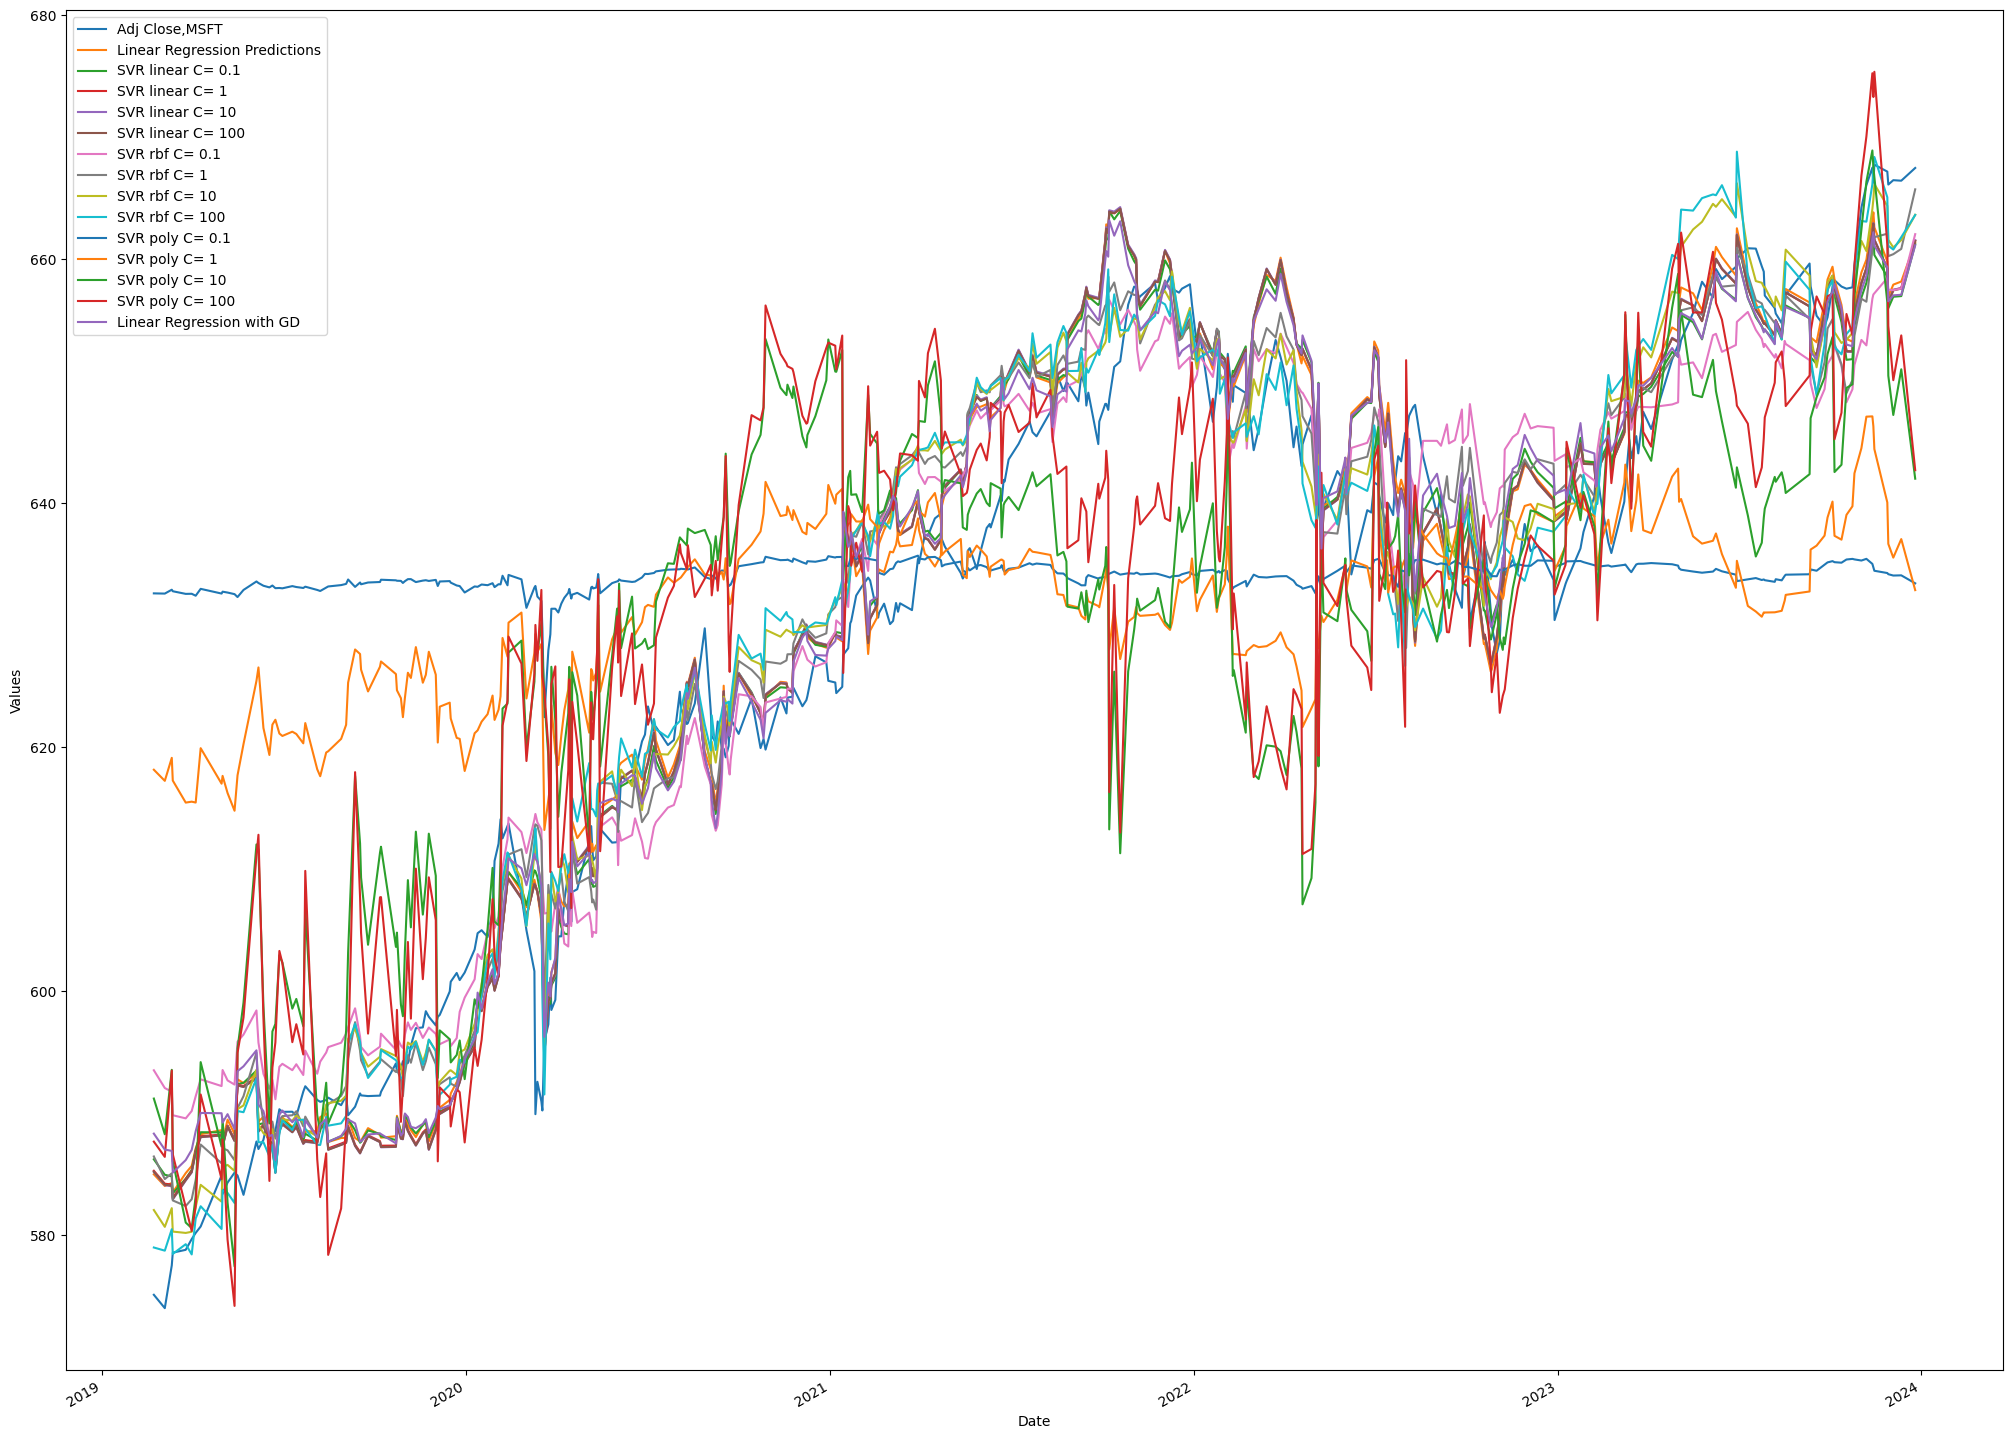

In [ ]:
### START CODE HERE ###
lines = df.plot.line(figsize=(25, 20))

# Set date range explicitly
# plt.xlim([pd.to_datetime('2022-05-01'), pd.to_datetime('2024-01-01')])

plt.xlabel('Date')
plt.ylabel('Values')

### END CODE HERE ###

### Question
1. Rank Top 3 Models with Best prediction (Best MSE)
2. What would be the reason for large error from 2023-05 to 2024-01?

In [ ]:
# Ans
1.Linear Regression,SVR (kernel:rbf),SVR (kernel:linear)
2.เพราะเป็นช่วงที่ตลาดหุ้นมีความผันผวนสูงทำให้คาดเดาได้ยาก